In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
from tensorflow.keras import regularizers
# Figure out how to import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [4]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2021-01-09 06:41:33--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.240, 172.217.15.80, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-01-09 06:41:33 (133 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [9]:
import tensorflow as tf
model = Sequential()
model.add(tf.keras.layers.Embedding(total_words,80,input_length=max_sequence_len-1))
model.add(LSTM(64, activation='relu',return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64,activation='relu'))
model.add(Dense(total_words/2,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words,activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 80)            256880    
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 64)            37120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1605)              104325    
_________________________________________________________________
dense_3 (Dense)              (None, 3211)              5156866   
Total params: 5,588,215
Trainable params: 5,588,215
Non-trainable params: 0
____________________________________________

In [10]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 22s 41ms/step - loss: 7.2930 - accuracy: 0.0214
Epoch 2/100
484/484 [==============================] - 19s 40ms/step - loss: 6.5472 - accuracy: 0.0202
Epoch 3/100
484/484 [==============================] - 20s 42ms/step - loss: 6.4893 - accuracy: 0.0239
Epoch 4/100
484/484 [==============================] - 19s 40ms/step - loss: 6.3524 - accuracy: 0.0215
Epoch 5/100
484/484 [==============================] - 20s 41ms/step - loss: 6.2670 - accuracy: 0.0319
Epoch 6/100
484/484 [==============================] - 20s 41ms/step - loss: 6.1563 - accuracy: 0.0363
Epoch 7/100
484/484 [==============================] - 19s 40ms/step - loss: 6.0585 - accuracy: 0.0349
Epoch 8/100
484/484 [==============================] - 20s 41ms/step - loss: 5.9701 - accuracy: 0.0420
Epoch 9/100
484/484 [==============================] - 20s 41ms/step - loss: 5.8955 - accuracy: 0.0420
Epoch 10/100
484/484 [==============================] - 20s 41ms/step - l

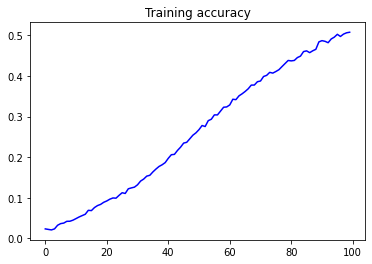

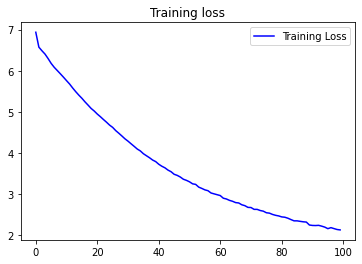

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [12]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope become my verse by day from night days friend ' of ' twain told thou feel'st the pain ' her tell your deeds comment away afloat growing pleasure light of stand pride light in rehearse ill night with day to day ' friend ' small pleasure shown ' ' in mine place one more contain alone i sing ' in your bastard skill survey end ' chide the very same ' praise set it quite asleep veins be lease sweet another shown days ' ' from my store ' gone each shall 'greeing days betray face grow stand ' worn
